**The answers in this notebook are based on the loan dataset pulled from https://www.bondora.com/en/public-reports on July 25th 2019.**

In [1]:
import scipy as sp
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import feature_selection as fs, model_selection as ms, ensemble, tree, metrics

In [2]:
df_full = pd.read_csv('./LoanData.csv', low_memory= False)
df_full.shape

(98762, 112)

In [3]:
pd.set_option('display.max_columns', len(df_full.columns))
df_full.head(10)

ReportAsOfEOD                                LoanId  LoanNumber  \
0    2019-07-25  9C2875B0-22EA-484C-85A7-9CD3014860ED        1480   
1    2019-07-25  E9CF2D86-9308-4F21-AFA0-9CD801855211        1513   
2    2019-07-25  FC48AC2C-CF68-454F-917C-9CD800B24E54        1502   
3    2019-07-25  B275CAD8-E560-4FFA-8D09-9CDB011091EA        1539   
4    2019-07-25  BFD4FC91-CF3D-4C02-814F-9CD5000F2141        1487   
5    2019-07-25  E33E98DC-9AEE-4FA9-85BA-9CD3012896F9        1479   
6    2019-07-25  37B354C9-2D46-45C4-A812-9CD70111C091        1499   
7    2019-07-25  BC799EA6-6F6B-4FFB-B308-9CD400F80138        1484   
8    2019-07-25  0EAB7669-26B1-4C35-A2C6-9CD30086A1CF        1474   
9    2019-07-25  AF96F32E-B9AC-42CE-A4D3-9C7100B991C6        1017   

           ListedOnUTC     BiddingStartedOn  BidsPortfolioManager  BidsApi  \
0  2009-12-02 19:55:35  2009-12-02 19:55:35                     0        0   
1  2009-12-07 23:37:28  2009-12-07 23:37:28                     0        0   
2  2009-12-07 10:49:11  2009-12-07 10:49:11                     0        0   
3  2009-12-10 16:32:23  2009-12-10 16:32:23                     0        0   
4  2009-12-04 00:55:05  2009-12-04 00:55:05                     0        0   
5  2009-12-02 17:59:51  2009-12-02 17:59:51                     0        0   
6  2009-12-06 16:36:42  2009-12-06 16:36:42                     0        0   
7  2009-12-03 15:02:57  2009-12-03 15:02:57                     0        0   
8  2009-12-02 08:10:10  2009-12-02 08:10:10                     0        0   
9  2009-08-26 11:15:38  2009-08-26 11:15:38                     0        0   

   BidsManual  UserName  NewCreditCustomer LoanApplicationStartedDate  \
0     31.9558    Mommik              False        2009-12-02 19:55:35   
1    102.2587  tibunike               True        2009-12-07 23:37:28   
2    191.7348    taglas               True        2009-12-07 10:49:11   
3     95.8674    daruus               True        2009-12-10 16:32:23   
4    639.1165     Siilu               True        2009-12-04 00:55:05   
5    319.5582       SSP               True        2009-12-02 17:59:51   
6    319.5582    tannur              False        2009-12-06 16:36:42   
7     51.1294  vahur120               True        2009-12-03 15:02:57   
8    166.1704    daruus               True        2009-12-02 08:10:10   
9    198.1260     neium               True        2009-08-26 11:15:38   

     LoanDate ContractEndDate FirstPaymentDate MaturityDate_Original  \
0  2009-12-07      2010-07-07       2010-01-11            2010-01-11   
1  2009-12-10      2012-05-15       2010-02-04            2010-04-05   
2  2009-12-12      2010-04-05       2010-02-08            2010-04-07   
3  2009-12-13      2012-11-14       2010-02-04            2011-01-04   
4  2009-12-14      2011-12-28       2010-01-28            2011-12-28   
5  2009-12-10      2010-03-10       2010-01-11            2010-03-10   
6  2009-12-09      2010-02-02       2010-01-28            2010-01-28   
7  2009-12-07      2010-01-15       2010-01-25            2010-12-27   
8  2009-12-04      2012-11-14       2010-01-28            2011-12-28   
9  2009-08-27      2009-10-05       2009-10-05            2009-10-05   

  MaturityDate_Last  ApplicationSignedHour  ApplicationSignedWeekday  \
0        2010-01-11                     19                         4   
1        2012-05-15                     23                         2   
2        2010-04-07                     14                         2   
3        2012-01-10                     16                         5   
4        2011-12-28                     11                         6   
5        2010-03-10                      1                         5   
6        2010-01-28                     16                         1   
7        2010-12-27                     15                         5   
8        2012-01-10                      8                         4   
9        2009-10-05                     11                        

# Q1
- Does the probability of default (variable ProbabilityOfDefault) depend on the borrower's age?
- If yes, by how much?
- Is it a strong dependency?

In [4]:
df = df_full[[ 'Age', 'ProbabilityOfDefault' ]].copy().dropna()

def get_corr_dict(df_2d):
    return { method: df_2d.corr(method= method).iloc[0,1] for method in ['pearson', 'spearman', 'kendall'] }

def print_corrs(df_2d):
    for method, corr in get_corr_dict(df_2d).items():
        print('{} \t {:.3f}'.format(method.capitalize(), corr))

In [5]:
print_corrs(df)

Pearson 	 -0.096
Spearman 	 -0.102
Kendall 	 -0.069


**First glance: there _may_ be an extremely weak negative linear relationship between the variables.**

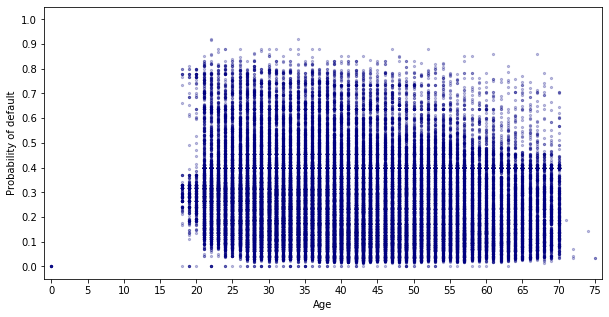

In [6]:
fig, ax = plt.subplots(figsize= (10, 5))

plt.xlabel('Age')
plt.xlim(-1, df['Age'].max() + 1)
plt.xticks(np.arange(0, df['Age'].max() + 1, 5))
plt.ylabel('Probability of default')
plt.ylim(-0.05, 1.05)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.scatter(df['Age'], df['ProbabilityOfDefault'], s= 5, c= 'navy', alpha= 0.25)

**Visual analysis confirms that there is a slight downwards trend in ProbabilityOfDefault as Age grows.**

<BarContainer object of 58 artists>

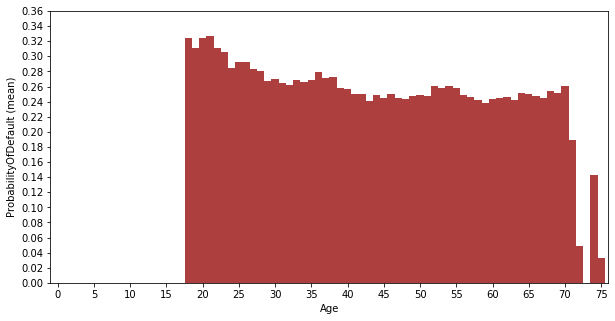

In [7]:
p_means = df.groupby('Age').mean()

fig, ax = plt.subplots(figsize= (10, 5))
plt.xlabel('Age')
plt.xlim(-1, df['Age'].max() + 1)
plt.xticks(np.arange(0, df['Age'].max() + 1, 5))
plt.ylabel('ProbabilityOfDefault (mean)')
plt.ylim(0, p_means.max().values[0] + 0.01)
plt.yticks(np.arange(0, p_means.max().values[0] + 0.05, 0.02))

plt.bar(list(p_means.index.values), list(map(lambda x: x[0], p_means.values)), 1, color= 'brown', alpha= 0.9)

**This relationship can also be visualized by looking at the mean ProbabilityOfDefault for every Age.**

In [8]:
print_corrs(pd.DataFrame(
    {
        'Age': list(p_means.index.values),
        'ProbabilityOfDefault': list(map(lambda x: x[0], p_means.values))
    }
))

Pearson 	 -0.353
Spearman 	 -0.729
Kendall 	 -0.596


**There is a moderate negative linear relationship between the mean ProbabilityOfDefault and Age.**

**It can be concluded that there is an exteremly weak, but significant dependency between ProbabilityOfDefault and Age.**

# Q2
- Are the rating distributions (variable Rating) of new borrowers (NewCretitCustomer=TRUE) the same or different in the three countries?

In [9]:
df = df_full[df_full['NewCreditCustomer'] == True][[ 'Rating', 'Country' ]].copy()
df['Rating'] = df['Rating'].fillna('N/A')

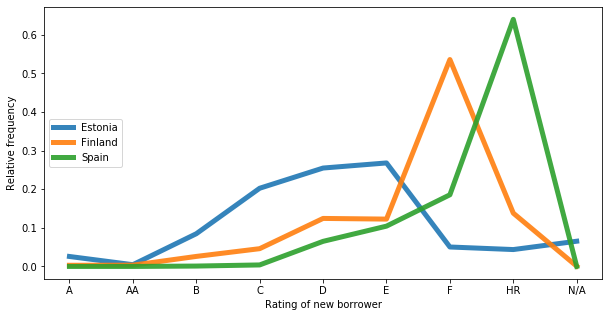

In [10]:
fig, ax = plt.subplots(figsize= (10, 5))

rating_labels = sorted(df['Rating'].unique())

plt.xlabel('Rating of new borrower')
plt.ylabel('Relative frequency')

for country in ['EE', 'FI', 'ES']:
    ratings = df[df['Country'] == country]['Rating'].value_counts()
    ratings /= ratings.sum()
    ratings = ratings.to_dict()
    for label in rating_labels:
        if label not in ratings:
            ratings[label] = 0
    points = list(map(lambda x: x[1], sorted(ratings.items(), key= lambda x: x[0])))
    plt.plot(rating_labels, points, linewidth= 5, alpha= 0.9)
    
plt.legend(['Estonia', 'Finland', 'Spain'], loc= 'center left')

**It is apparent that new borrower rating distributions are different in each country.**

# Q3

Consider only the variables Country, Education, MaturityDate and NewCreditCustomer.

- Which of them would you most likely include in the model for predicting borrower's default?

(Use the DefaultDate variable as the indicator of a default - the loan has not defaulted when DefaultDate is missing)

**Given its nature and context, the variable MaturityDate can be immediately discarded as misleading; if included, it would inevitably cause the model to overfit.**

In [11]:
FEATS = ['Country', 'Education', 'NewCreditCustomer']

df = df_full[FEATS + ['DefaultDate']].copy()
df['Education'] = df['Education'].fillna('N/A')
df['Default'] = ~df['DefaultDate'].isna()
df = df.drop(columns= ['DefaultDate'])

In [12]:
def get_contingency_table(r, c):
    ctable = []
    ck = c.value_counts().keys()
    for uqr in r.unique():
        fqs = { k: 0 for k in ck }
        for k, v in c[r == uqr].value_counts().items():
            fqs[k] = v
        ctable.append(list(map(lambda e: e[1], sorted(fqs.items(), key= lambda e: e[0]))))
    return ctable

chis = {}

for feat in FEATS:
    chi, pval, dof, exp = sp.stats.chi2_contingency(get_contingency_table(df[feat], df['Default']))
    crit = sp.stats.chi2.ppf(0.95, dof)
    chis[feat] = {
        'chi': chi,
        'crit': crit,
        'p-value': pval
    }

chis = pd.DataFrame(chis).T
chis

chi       crit  p-value
Country            7847.280430   7.814728      0.0
Education          1715.872600  14.067140      0.0
NewCreditCustomer  2117.099064   3.841459      0.0

**The chi-squared test for independence suggests that all three variables are in a relationship with the target variable, so none can be discarded outright.**

In [13]:
print('Mutual information w/ `Default`')

dff = df.copy()
for feat in FEATS: dff[feat], _ = pd.factorize(dff[feat])
for f, i in zip(dff.columns, fs.mutual_info_classif(dff[FEATS], df['Default'].astype(int), discrete_features= True)):
    print('{:<22} {:.3f}'.format(f, i))

Mutual information w/ `Default`
Country                0.039
Education              0.008
NewCreditCustomer      0.011


**The measure of mutual information with the target variable shows that Country has the most significance.**

In [14]:
aucs = []
importances = np.asarray([0.0] * 3)
kf = ms.StratifiedKFold(n_splits= 5)
for train_idx, test_idx in kf.split(dff[FEATS], dff['Default']):
    clf = ensemble.RandomForestClassifier(n_estimators= 100, max_depth= 2, max_features= None, random_state= 17)
    clf.fit(dff.iloc[train_idx][FEATS], dff.iloc[train_idx]['Default'].astype(int))
    y_pred = clf.predict(dff.iloc[test_idx][FEATS])
    aucs.append(metrics.roc_auc_score(dff.iloc[test_idx]['Default'], y_pred))
    importances += clf.feature_importances_

aucs = np.asarray(aucs)
print('Random forest ROC AUC: {:.2f} +- {:.2f}'.format(aucs.mean(), aucs.std()))
print('Feature importances:')
for f, i in zip(dff.columns, importances / 5):
    print('{:<22} {:.3f}'.format(f, i))

Random forest ROC AUC: 0.59 +- 0.07
Feature importances:
Country                0.911
Education              0.001
NewCreditCustomer      0.088


**A basic wrapper test confirms that Country is the most important variable.**

# Q4

Using only variables Country, Education and NewCreditCustomer and consider only segements with over 1000 observations - find a segment of customers having the lowest possible default rate.

- What is the segment size?

In [15]:
df = df_full[['Country', 'Education', 'NewCreditCustomer', 'DefaultDate']].copy()
df['Education'] = df['Education'].fillna('N/A')
df['Default'] = ~df['DefaultDate'].isna()
df = df.drop(columns= ['DefaultDate'])

In [16]:
seg_rates = []

segments = df.groupby(['Country', 'Education', 'NewCreditCustomer'])
for grp, idx in zip(segments.indices, segments.apply(lambda x: list(x.index))):
    if len(idx) <= 1000:
        continue
    d = df.iloc[idx]['Default']
    default_rate = len(d[d == True]) / len(d)
    seg_rates.append({
        'Country': grp[0],
        'Education': grp[1],
        'NewCreditCustomer': grp[2],
        'SegmentSize': len(idx),
        'DefaultRate': default_rate
    })

seg_rates = pd.DataFrame(seg_rates, columns= ['Country', 'Education', 'NewCreditCustomer', 'SegmentSize', 'DefaultRate'])
seg_rates[seg_rates['DefaultRate'] == seg_rates['DefaultRate'].min()]

Country  Education  NewCreditCustomer  SegmentSize  DefaultRate
8      EE        5.0              False         7951     0.133317

**The lowest possible default rate of 13.33% is found within the segment of returning customers who are based in Estonia and have a higher education. The segment size is 7951.**

# Q5

Consider the ProbabilityOfDefault variable - this is the model's prediction for the corresponding loan to default, made at the time the loan was issued.
Consider only the loans with FirstPaymentDate between Jan 1st 2016 and Nov 1st 2017.
- Was the prediction model well calibrated at that period (i.e. did the predicted rates match the actual default rates)?
- Was the model well calibrated within each Country?

In [17]:
df = df_full[['FirstPaymentDate', 'Country', 'ProbabilityOfDefault', 'DefaultDate']].copy()
df['FirstPaymentDate'] = pd.to_datetime(df['FirstPaymentDate'])
df = df[(df['FirstPaymentDate'] >= '2016-01-01') & (df['FirstPaymentDate'] <= '2017-11-01')]
df['Default'] = (~df['DefaultDate'].isna()).astype(float)
df = df.drop(columns= ['DefaultDate'])

In [18]:
N_BINS = 100
BIN_OFFSET = 0.5 / N_BINS
df['ProbabilityOfDefault_Binned'] = pd.cut(df['ProbabilityOfDefault'], bins= np.arange(0, 1.01, 1 / N_BINS), right= False)

def plot_calibration(df, title):
    actual = df.groupby('ProbabilityOfDefault_Binned')['Default'].mean()
    counts = df.groupby('ProbabilityOfDefault_Binned')['ProbabilityOfDefault'].count()
    print('Brier score ({}): {:.3f}'.format(title, metrics.brier_score_loss(df['Default'], df['ProbabilityOfDefault'])))
    plt.subplots(figsize= (13, 10))
    plt.title(title)
    plt.xlabel('Mean actual default rate')
    plt.xlim(-0.025, 1.025)
    plt.xticks(np.arange(0, 1.01, 0.05))
    plt.ylabel('Predicted ProbabilityOfDefault')
    plt.ylim(-0.025, 1.025)
    plt.yticks(np.arange(0, 1.01, 0.05))
    plt.plot([0, 1], [0, 1], c= 'green', linestyle= '--', alpha= 0.75)
    plt.scatter(actual.values, np.arange(BIN_OFFSET, 1 + BIN_OFFSET, 1 / N_BINS),  marker='o', s= counts.values, alpha= 0.75, c= counts.values, cmap= 'gnuplot')
    plt.colorbar()

Brier score (All countries): 0.281


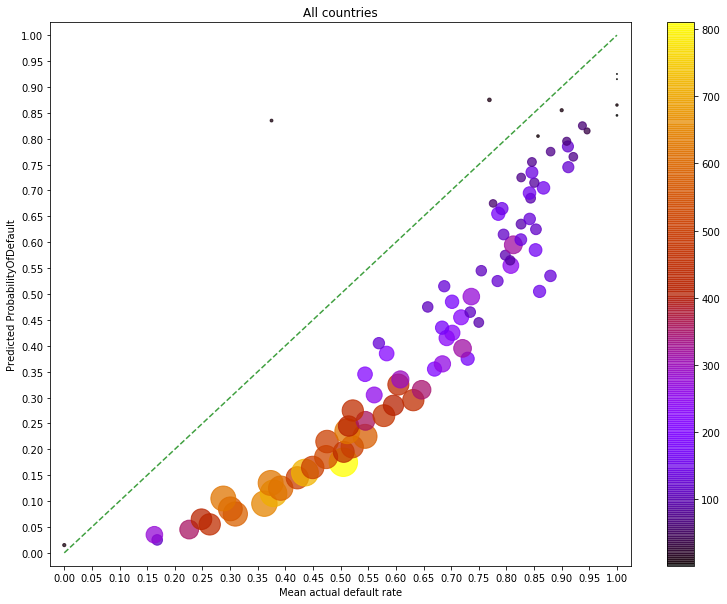

In [19]:
plot_calibration(df, 'All countries')

**The model was not calibrated too well during the period in question - the predictions were consistently lower than the actual default rates.**

**Overall calibration issues were not extreme, though, since the right trend was present, the spread was more or less tight and there were very few outliers.**

Brier score (EE-specific predictions): 0.279
Brier score (FI-specific predictions): 0.372
Brier score (ES-specific predictions): 0.228


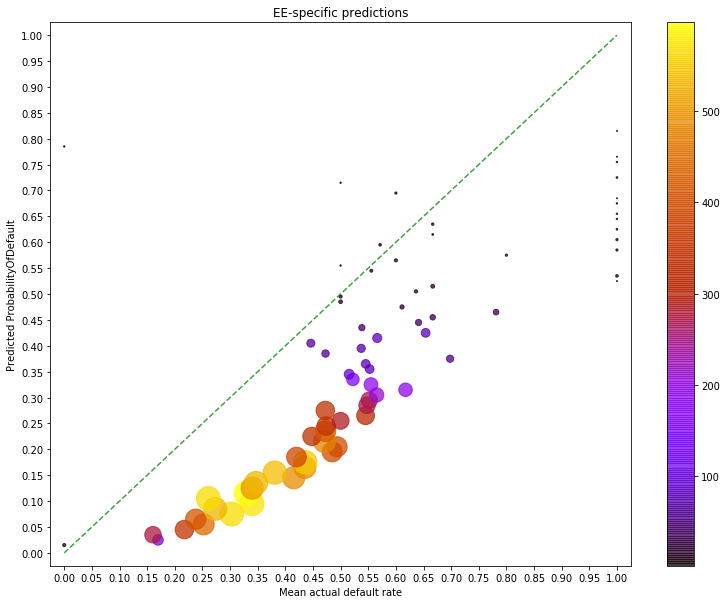

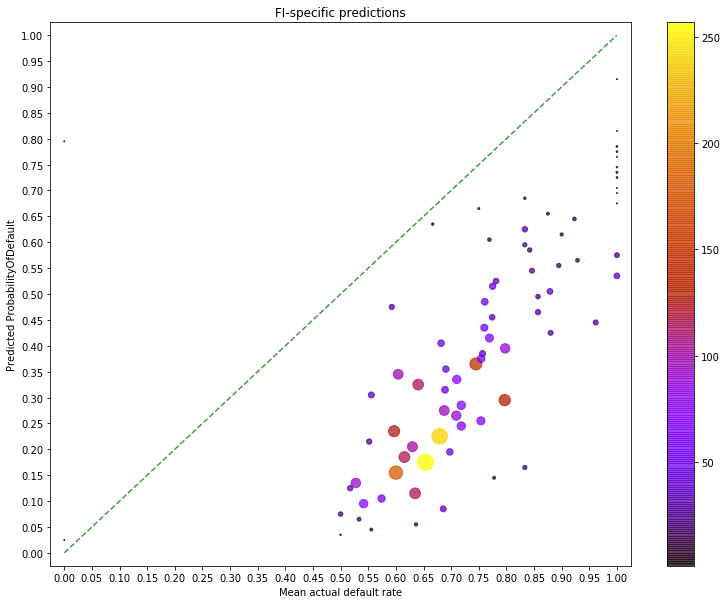

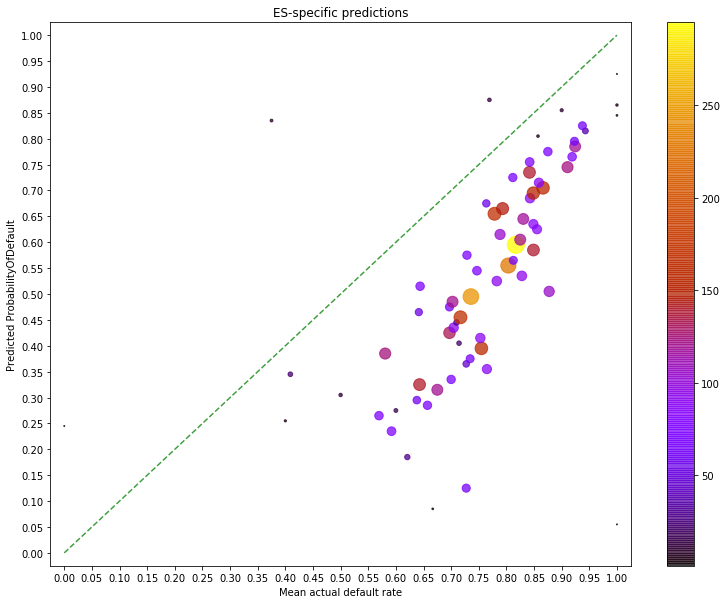

In [20]:
for country in ['EE', 'FI', 'ES']:
    plot_calibration(df[df['Country'] == country], '{}-specific predictions'.format(country))

**Country-specific calibration was definitely off, especially for Finland and Spain.**

**With a few adjustments, the majority of predictions for Estonia would have been accurate at the expense of overestimated default probabilities for higher risk loans.**